# FaceNet

In [ ]:
#| default_exp facenet

In [ ]:
#| hide
from similarity_learning.utils import *

In [ ]:
#| export
from facenet_pytorch import InceptionResnetV1, fixed_image_standardization

from similarity_learning.utils import *
from similarity_learning.siamese import *
from similarity_learning.pair_matching import *


class FaceNetInceptionResnetV1(InceptionResnetV1):
    """Like `pytorch_facenet`'s `InceptionResnetV1` but accepts standard float tensors"""
    def __init__(self, pretrained=True, classify=True):
        if pretrained is True:
            pretrained = 'vggface2'
        super().__init__(pretrained, classify)

    def forward(self, x):
        x = fixed_image_standardization(x * 255)
        return super().forward(x)


def facenet(pretrained=True) -> ThresholdSiamese:
    """A binary classifier matching pairs of facial images"""
    backbone = FaceNetInceptionResnetV1(pretrained, classify=False)
    backbone = cut_model_by_name(backbone, 'last_bn')  # skip normalization in case we want unnormalized features
    return ThresholdSiamese(backbone)

In [ ]:
from fastai.vision.all import *
from fastai_datasets.all import *

## Performance on LFW

Let's start by quickly evaluating on the development view of LFW:

In [ ]:
dls = LFWPairs().dev().dls()
face_matcher = facenet()

face_matcher.fit_threshold(dls.train)
learn = Learner(dls, face_matcher, metrics=accuracy)
learn.validate()

(#2) [0.22585052251815796,0.9919999837875366]

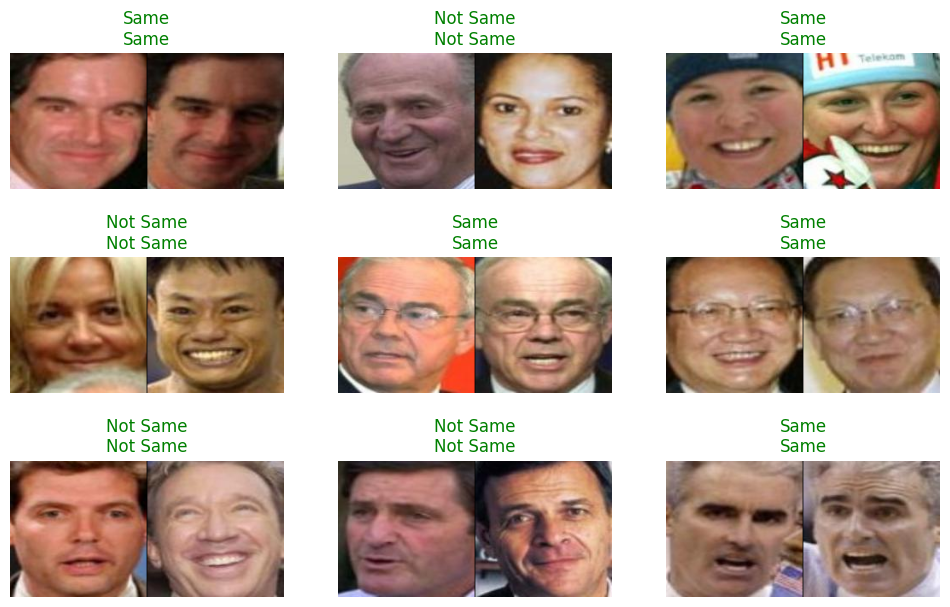

In [ ]:
learn.show_results()

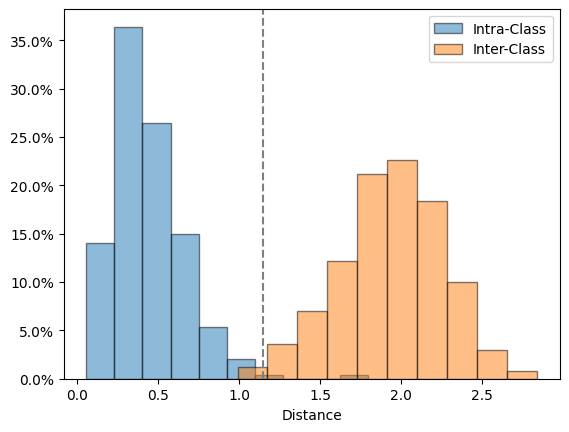

In [ ]:
face_matcher.plot_distance_histogram(dls.valid)

We can also evaluate the test accuracy (as defined by LFW - 10-fold cross validation on the test view):

In [ ]:
class FacenetCrossValidation(Experiment):
    def iteration(self):
        self.model.fit_threshold(self.dls.train)
        return Learner(self.dls, self.model, metrics=accuracy).validate()

In [ ]:
res = FacenetCrossValidation(facenet('vggface2'), LFWPairs().test()).run()
_, mean_accuracy = res.mean_stats
print(as_percentage(mean_accuracy))

99.35%


## Performance on SLLFW

For a quick evaluation, let's use the first cross-validation split (since SLLFW doesn't have a dev view)

In [ ]:
dls = SLLFWPairs().test()[0].dls()
face_matcher = facenet()

face_matcher.fit_threshold(dls.train)
learn = Learner(dls, face_matcher, metrics=accuracy)
learn.validate()

(#2) [0.36826473474502563,0.9466666579246521]

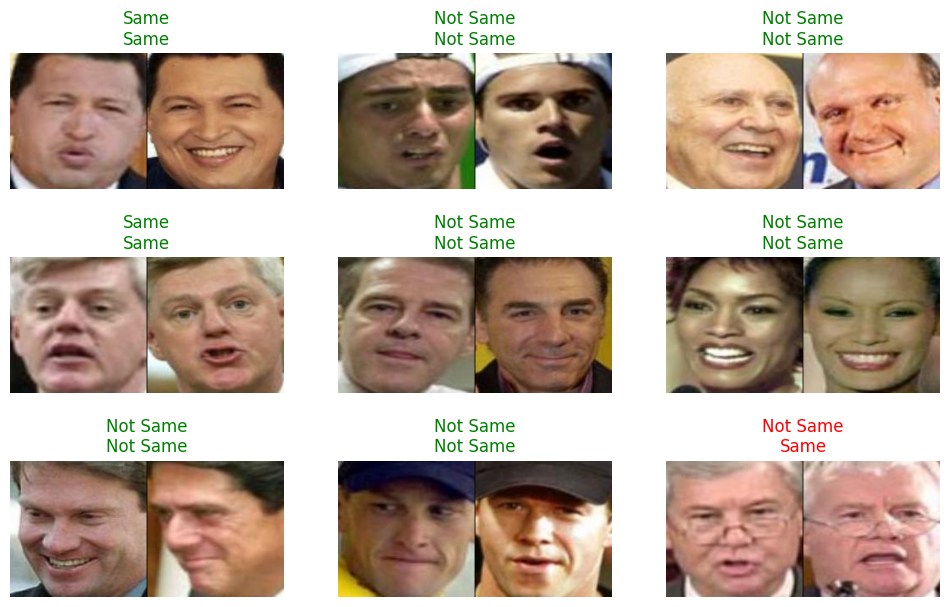

In [ ]:
learn.show_results()

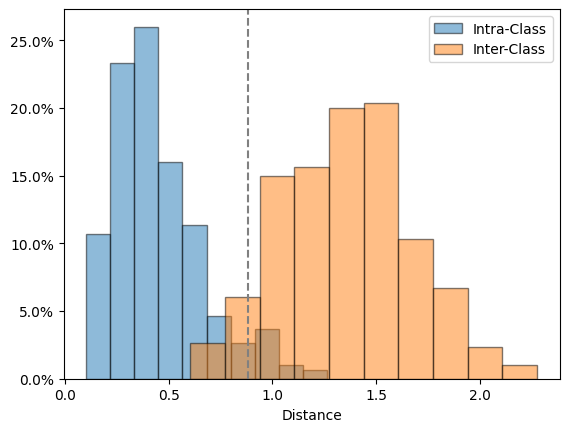

In [ ]:
face_matcher.plot_distance_histogram(dls.valid)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()